In [1]:
# Visualization of activity difference between a classical neural network and a FGnet

# DEV: different underlying gaussian - looks like a reverse N

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [6]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [7]:
total_num_samples = 2048

# random moons
samples, labels = datasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# random concentric circles
# samples, labels = datasets.make_circles(n_samples=total_num_samples, noise=0.08, factor=0.4, shuffle=True)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]

print(np.shape(train_samples))
print(type(train_samples))

# # add noise?
# X1 = np.arange(-10.0, 10.01, 0.5)
# X1s, X2s = np.meshgrid(X1,X1)
# noise_samples = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
# noise_labels = [np.random.choice([0,1]) for _ in range(len(labels))]

# train_samples = np.concatenate((train_samples ,noise_samples))
# train_labels = np.concatenate((train_labels ,noise_labels))

print(np.shape(train_samples))
print(type(train_samples))

num_samples = len(train_samples)

(1638, 2)
<type 'numpy.ndarray'>
(1638, 2)
<type 'numpy.ndarray'>


<IPython.core.display.Javascript object>


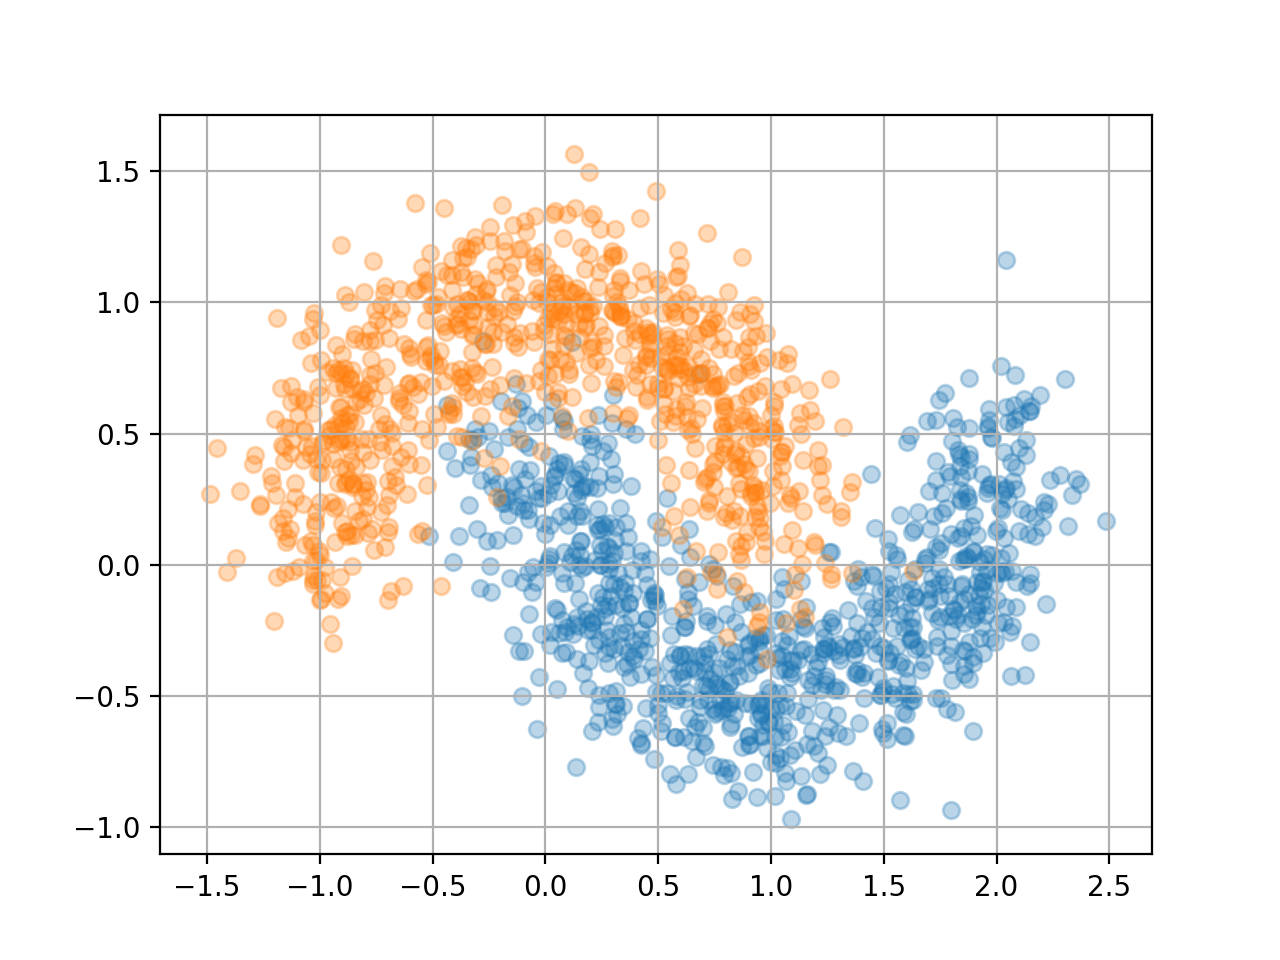

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]

plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3)

plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=192, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, shuffle=True) # create your dataloader

In [10]:
### function to change

In [11]:
# define the FGN layer class to dev

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 

class FGN_layer(nn.Module):
    r""" Applies a Finite Gaussian Neuron layer to the incoming data
    
    Args:
    
    Shape:
    
    Attributes:
    
    Examples:
        
        >>> l=FGN_layer(20,30)
    
    """
    def __init__(self, in_features, out_features, noisy_centers=False):
        super(FGN_layer, self).__init__()
        # input dimension
        self.in_features = in_features
        # output dimension
        self.out_features = out_features
        # should noise be added to the centers during training?
        self.noisy_centers = noisy_centers
        # noise scale
        self.scale = max(1e-6, np.sqrt(self.in_features))/1000.0

        
        # learnable parameters
        # regular NN weights (transposed at the start, see order of Tensor(dims))
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad=True)
        # centers of FGNs
        self.centers = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad=True)
        # size of FGNs
        self.sigmas = nn.Parameter(torch.Tensor(out_features,), requires_grad=True)
        # batchnorm ?
#         self.bn = nn.BatchNorm1d(out_features)
        
        # parameter init call
        self.reset_parameters()
    
    # parameter init definition
    def reset_parameters(self):
        s = np.sqrt(self.in_features)
        # regular NN init
        self.weights.data.uniform_(-s, s)
        # centers init, assuming data normalized to mean 0 var 1
        s = np.sqrt(self.in_features)
        self.centers.data.normal_(std=0.1)
        # size init, to be researched further
        s = np.sqrt(self.in_features)
#         s = self.in_features
#         s = np.log2(self.in_features)
        self.sigmas.data.uniform_(s, s)
        
    def forward(self, input):
        
        # linear part is the same as normal NNs
        biases = -torch.sum(torch.mul(self.weights, self.centers), dim=-1)
        l = F.linear(input, self.weights, bias=biases)
        # optional, apply tanh here
        # l = torch.tanh(l)
        # apply batchnorm here?
#         l = self.bn(l)

        # gaussian component
        # unsqueeze the inputs to allow broadcasting
        # distance to centers
        g = input.unsqueeze(1)-self.centers
        # add noise if in training
        if (self.noisy_centers and self.training):
            c_noise = torch.Tensor(np.random.normal(scale=self.scale, size=self.centers.size()))
            # send to device
            c_noise = c_noise.cuda()
            g = g+c_noise
        # square for euclidean dist
        g = g**2
        # sum along axis
        g = g.sum(dim=2)
        
        g = torch.clamp(g, min=-10.0, max=10.0)

        # for future, use any norm instead?
#         g = torch.norm(input.unsqueeze(1)-self.centers, p=1, dim=2)

        # apply sigma
        eps = 1e-3 #minimum sigma
        g = -g/(torch.clamp(self.sigmas, min=eps)**2 )
#         g = -g/self.sigmas**2
        # apply exponential
        g = torch.exp(g)
        
#         # if g small -> random
#         g = torch.max(g, 1e-3*torch.rand(g.size()).cuda() )

        # combine gaussian with linear
        res = l*g
        # optional, flatten res with extra non-linearity
        # res = F.tanh(res)

        return res
    

In [12]:
# Feedforward Finite Gaussian Neural Network model

import torch.nn as nn
import torch.nn.functional as F
import torch

class dev_Feedforward_FGN_net(nn.Module):
    
    def __init__(self,in_feats, out_feats, hidden_l_nums, drop_p=0.0, noisy_centers=False):
        super(dev_Feedforward_FGN_net, self).__init__()
        
        # input dimension
        self.in_feats=in_feats
        # output imension (number of classes)
        self.out_feats=out_feats
        # dropout prob (same throughout network)
        self.drop_p = drop_p
        # should noise be added to the centers during training?
        self.noisy_centers = noisy_centers
        
        # the hidden layers
        # add modules
        self.hidden_layers = nn.ModuleList([])

        # optional input dropout
        if drop_p > 0:
            self.hidden_layers.append(nn.Dropout(p=self.drop_p)) 
        
        # input batchnorm
        self.ib = nn.BatchNorm1d(self.in_feats)
        
        # add in the variable layers
        next_in = self.in_feats
        for idx, next_out in enumerate(hidden_l_nums):
            # the FGN layer
            self.hidden_layers.append(FGN_layer(next_in, next_out,noisy_centers=self.noisy_centers))
            # optional: batchnorm
            self.hidden_layers.append(nn.BatchNorm1d(next_out))
            # optional: dropout layer
            if drop_p > 0:
                self.hidden_layers.append(nn.Dropout(p=self.drop_p))
            # reset feat for next layer
            next_in = next_out

        # final layer
        self.fl = FGN_layer(next_in, self.out_feats)
        # final layer batchnorm
#         self.flb = nn.BatchNorm1d(self.out_feats)
        
    def forward(self, x):
        # squash the data
        x = x.view(-1, self.in_feats)
        # input batchnorm
        x = self.ib(x)
        # for each hidden layer
        for layer in self.hidden_layers:
            # apply layer (finite, batchnorm or dropout)
            x = layer(x)
            # if FGN_layer, apply non-linerarity (only needed to replicate classic net behavior)
#             if isinstance(layer, FGN_layer):
#                 x = torch.tanh(x)
        # final out layer
        x= self.fl(x)
        # final layer batchnorm
#         x = self.flb(x)
        # NO softmax
#         x = F.log_softmax(x, dim=-1)
        
        return x

In [13]:
### PART 1: classic feedforward net (linear with bias + tanh)

In [14]:
# # loss functions for the classic net
# lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
# print(lmbda_l2)
      
# classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

In [15]:
# Initialize the classic network
hidden_l_nums = [20,20,20,20]
drop_p = 0.

In [16]:
# classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [17]:
# # define model params to optimize
# classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [18]:
epochs = 5

In [19]:
# # train the network for N epochs
# classic_train_res = fgnh.train(classic_model, my_dataloader, 
#                              classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
#                              pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

In [20]:
# # test the statibility of the model (these numbers should be same as final lines above)
# classic_test_res = fgnh.test(classic_model, my_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# classic_test_res = fgnh.test(classic_model, my_test_dataloader,
#                         classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

In [21]:
# scale of the heat maps
X1 = np.arange(-10.0, 10.01, 0.1)
X1s, X2s = np.meshgrid(X1,X1)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(heatmap_inputs))
heatmap_inputs = torch.Tensor(heatmap_inputs)
print(type(heatmap_inputs))
# print(heatmap_inputs)

shape of heatmap (40401, 2)
<class 'torch.Tensor'>


In [22]:
# # compute predictions for heatmap
# classic_model.eval()
# classic_heatmap_preds = classic_model(heatmap_inputs.to(device))
# classic_heatmap_preds = classic_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# classic_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in classic_heatmap_preds])

In [23]:
# # plot the heatmap
# levels = np.arange(-0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(classic_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])

# plt.grid(True)
# plt.show()

In [24]:
### PART 2: new underlying gaussian

In [25]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 100.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)


fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

lambda for l2 loss 0.0002442002442
lambda for sigs^2 loss 0.02442002442


In [26]:
# Initialize the fgn network
print("hidden layers:", hidden_l_nums)
print("drop prob:", drop_p)
noisy_centers = True
print("noisy centers:", noisy_centers)
dev_model = dev_Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums,
                                     drop_p=drop_p, noisy_centers=noisy_centers).to(device)

hidden layers: [20, 20, 20, 20]
drop prob: 0.0
noisy centers: True


In [27]:
# define model params to optimize
dev_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, dev_model.parameters()),momentum=0.5)

In [28]:
# train the network for N epochs
dev_train_res = fgnh.train(dev_model, my_dataloader, 
                             fgn_cross_ent_loss, dev_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 1.0741, Accuracy: 1320/1638 (81%)
Test set - Average loss: 12.5718, Accuracy: 217/410 (53%)
Epoch 1 Train set - Average loss: 0.4765, Accuracy: 1563/1638 (95%)
Test set - Average loss: 4.1160, Accuracy: 218/410 (53%)
Epoch 2 Train set - Average loss: 0.4596, Accuracy: 1553/1638 (95%)
Test set - Average loss: 1.7629, Accuracy: 185/410 (45%)
Epoch 3 Train set - Average loss: 0.4216, Accuracy: 1567/1638 (96%)
Test set - Average loss: 0.9665, Accuracy: 304/410 (74%)
Epoch 4 Train set - Average loss: 0.4044, Accuracy: 1563/1638 (95%)
Test set - Average loss: 0.6731, Accuracy: 346/410 (84%)


In [29]:
# compute predictions for heatmap
dev_model.eval()
dev_heatmap_preds = dev_model(heatmap_inputs.to(device))
dev_heatmap_preds = dev_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
dev_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in dev_heatmap_preds.astype('float128')])

<IPython.core.display.Javascript object>


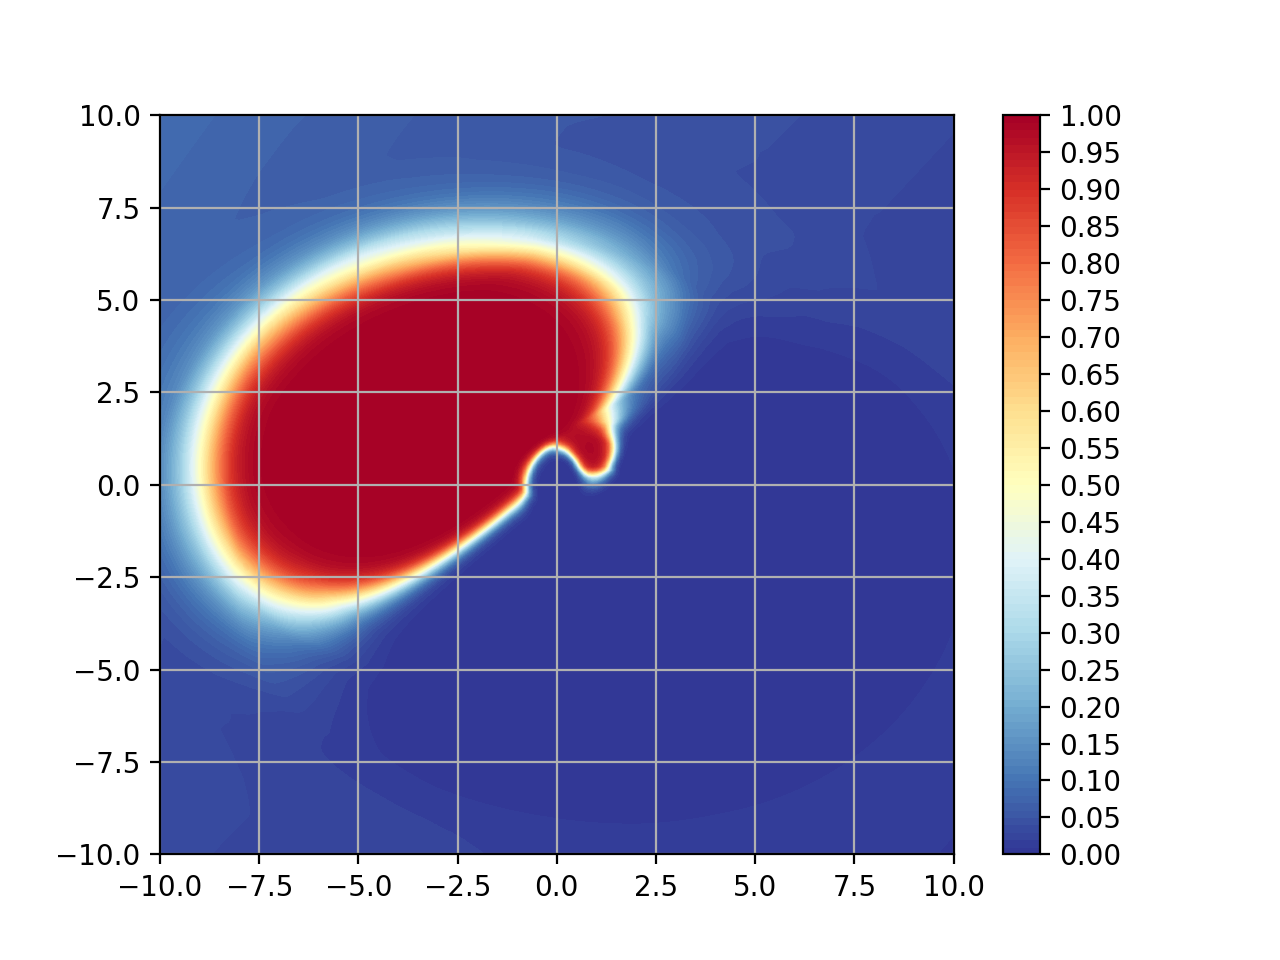

In [30]:
# plot the heatmap
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(dev_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# # uncomment if you want to see the data and tighten the window
# plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


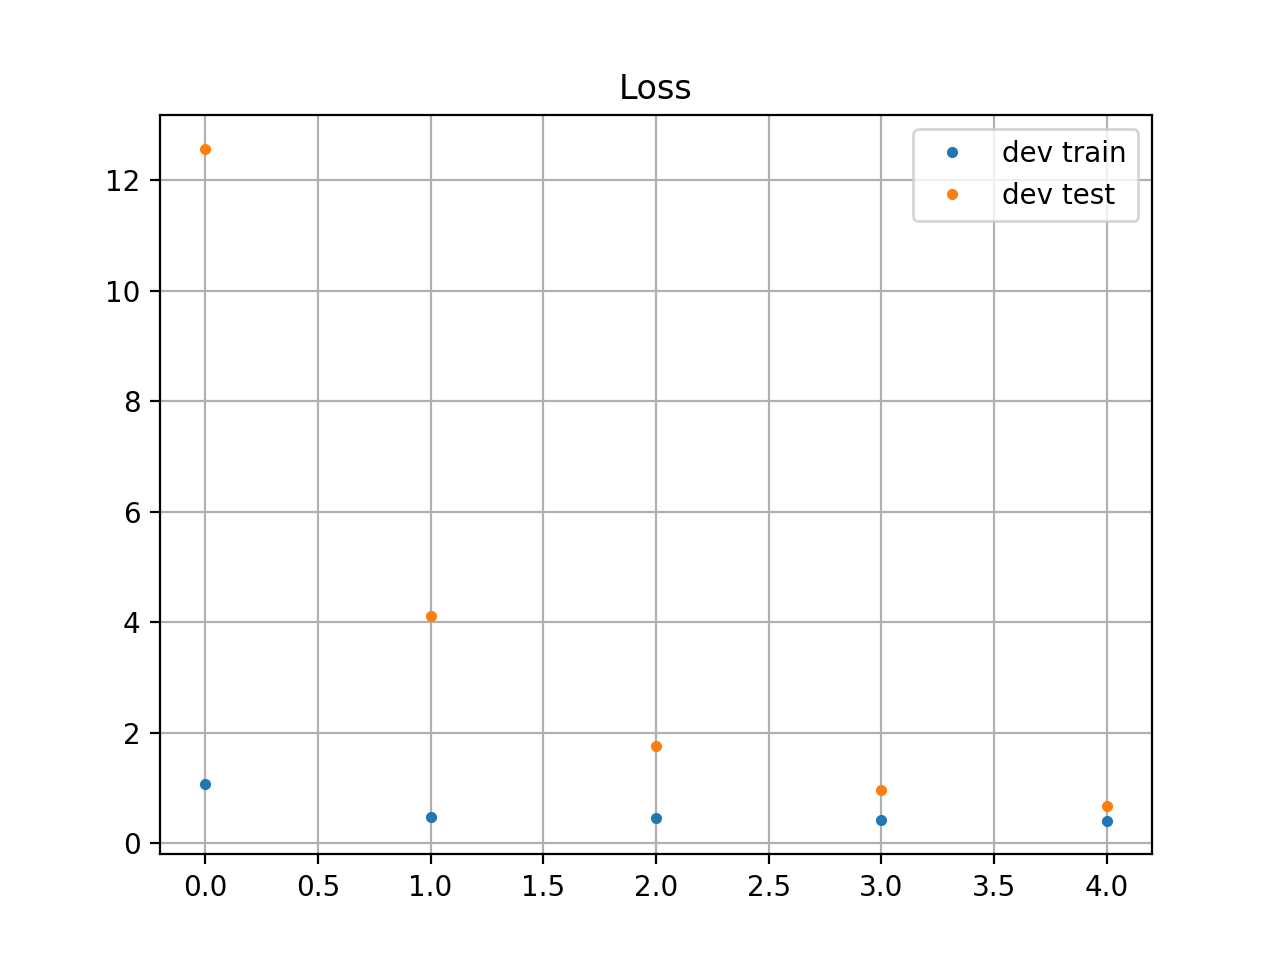

<IPython.core.display.Javascript object>


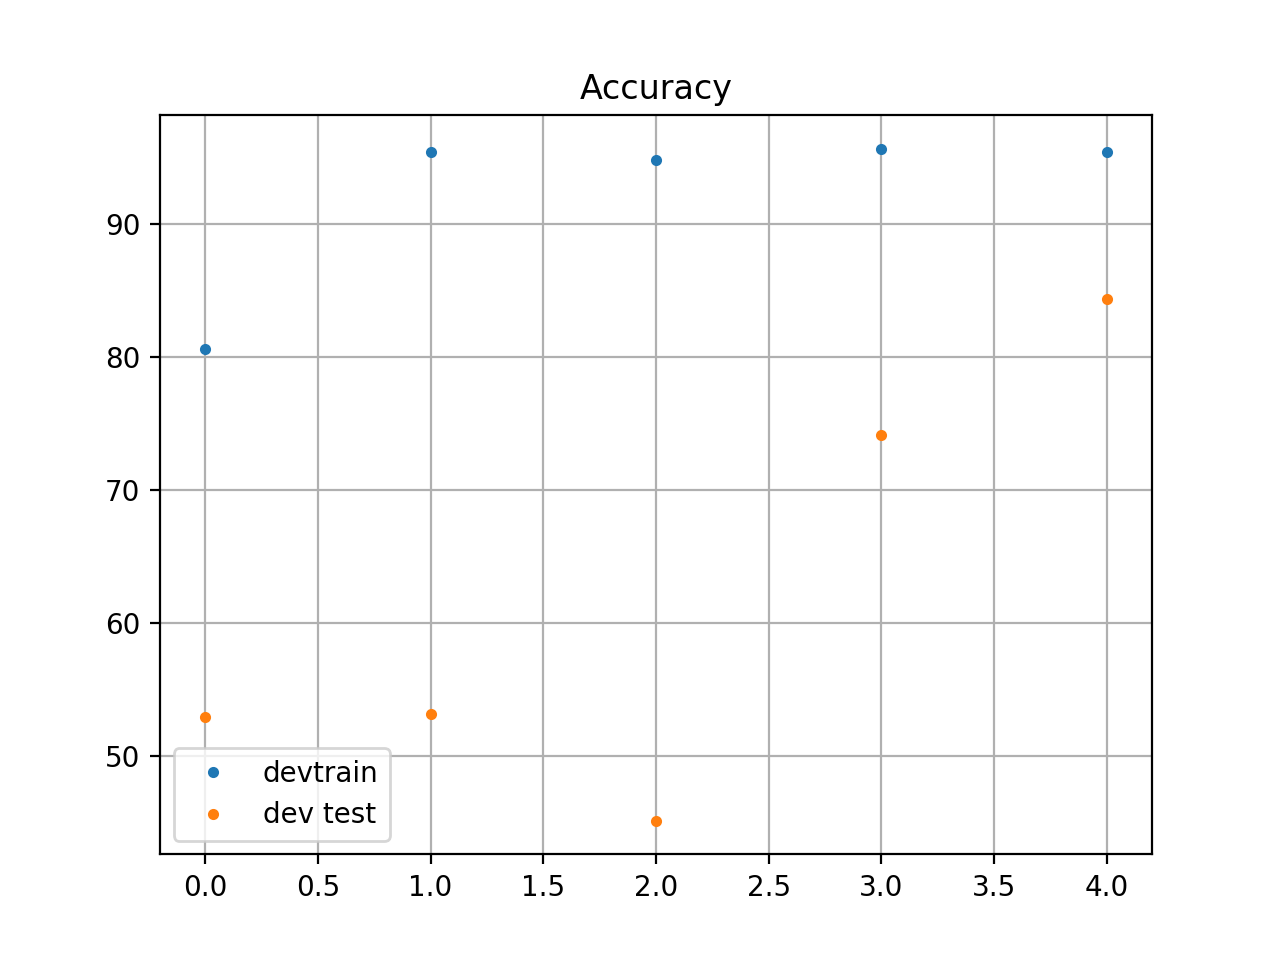

In [31]:
# acc and loss hist
plt.plot(dev_train_res['train_loss_hist'], marker='.', linestyle=' ', label='dev train')
plt.plot(dev_train_res['test_loss_hist'], marker='.', linestyle=' ', label='dev test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(dev_train_res['train_acc_hist'], marker='.', linestyle=' ', label='devtrain')
plt.plot(dev_train_res['test_acc_hist'], marker='.', linestyle=' ', label='dev test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [32]:
### plot some FGN param movement during training

hidden_layers.4.centers
plotting neurons: [ 8 15]


<IPython.core.display.Javascript object>


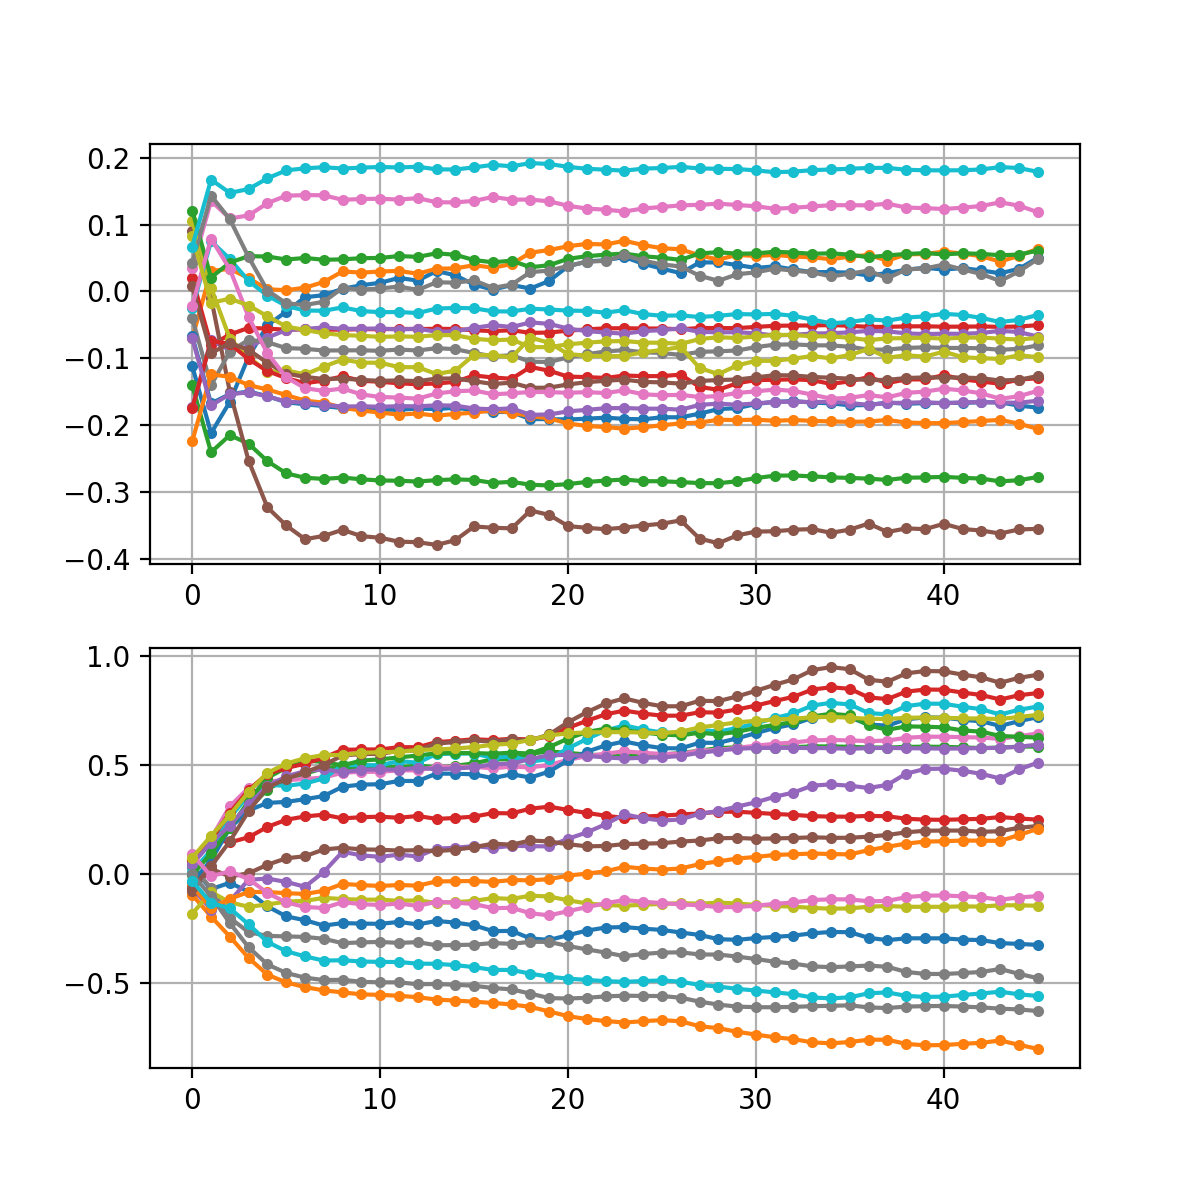

hidden_layers.0.centers
plotting neurons: [11  0]


<IPython.core.display.Javascript object>


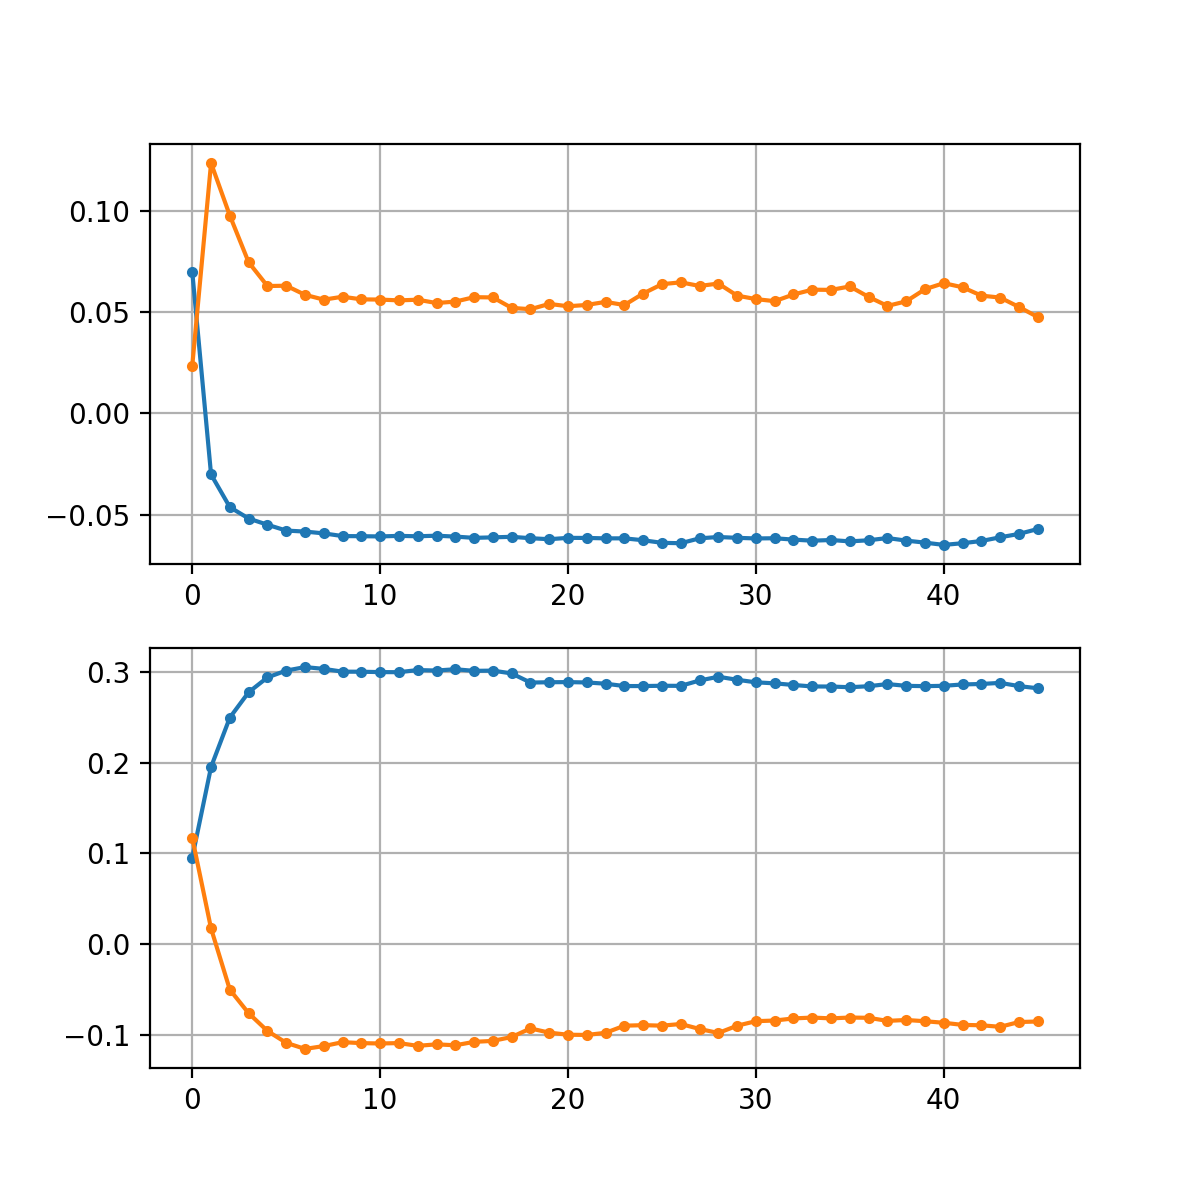

hidden_layers.6.centers
plotting neurons: [5 7]


<IPython.core.display.Javascript object>


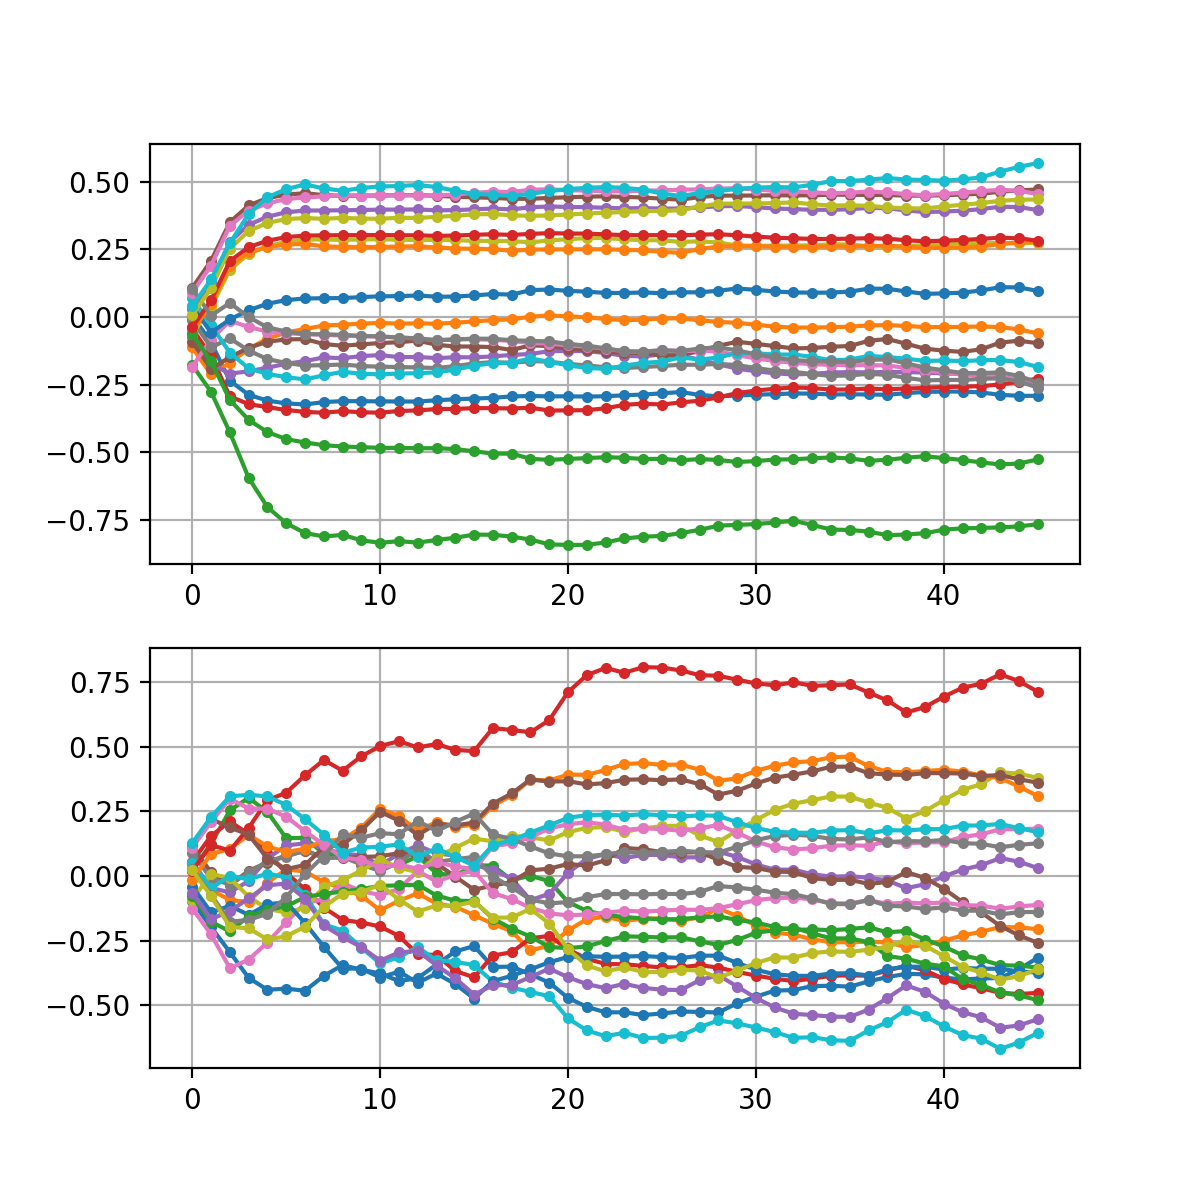

hidden_layers.2.centers
plotting neurons: [ 7 14]


<IPython.core.display.Javascript object>


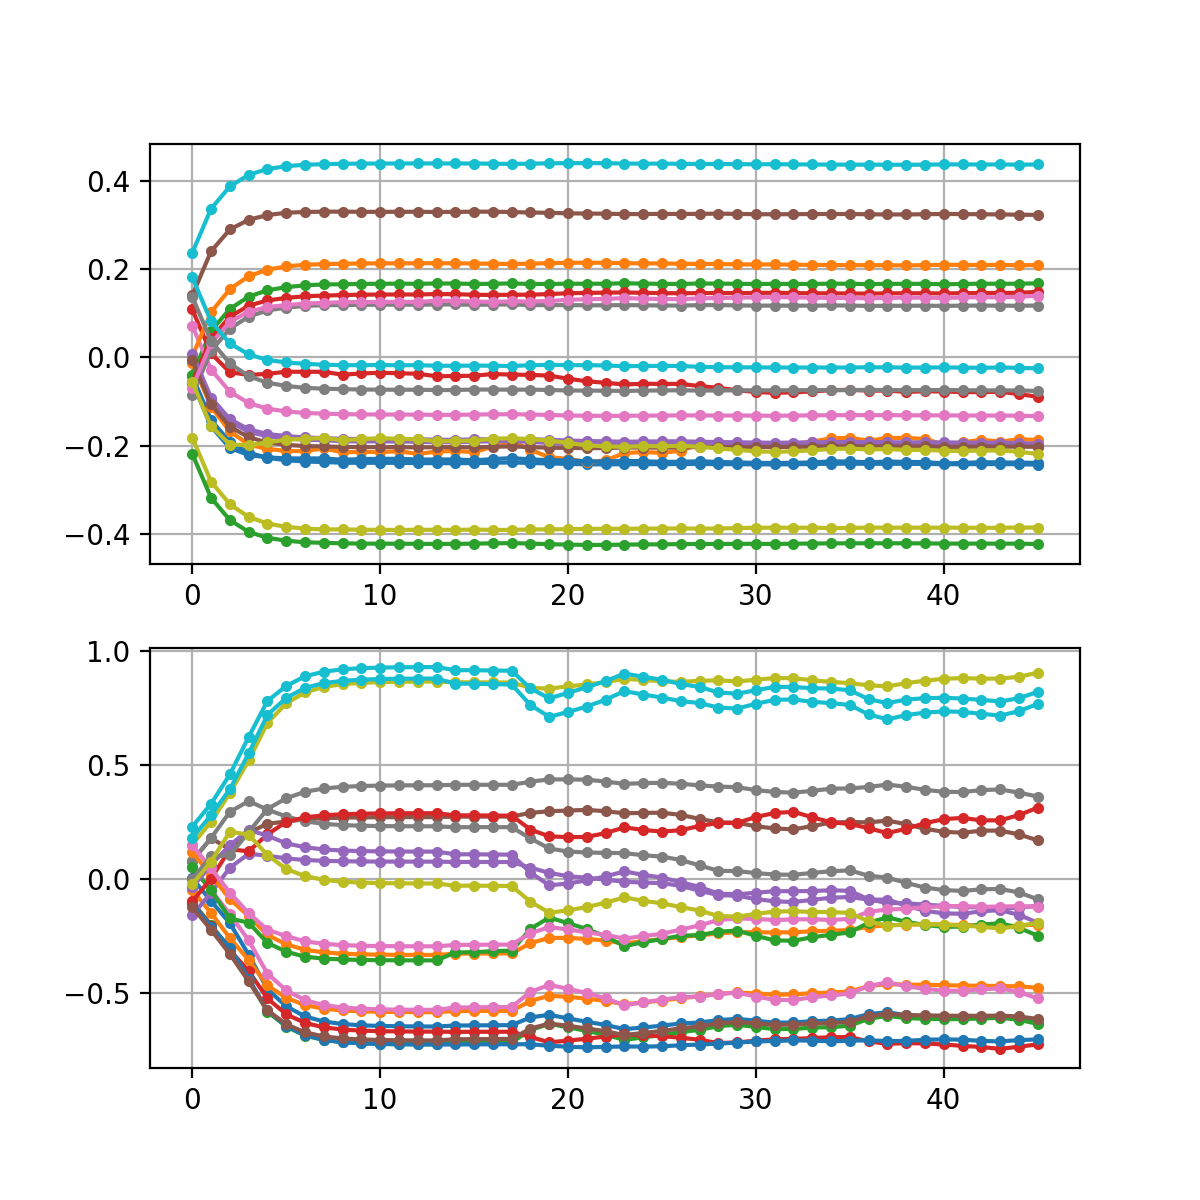

fl.centers
plotting neurons: [1 0]


<IPython.core.display.Javascript object>


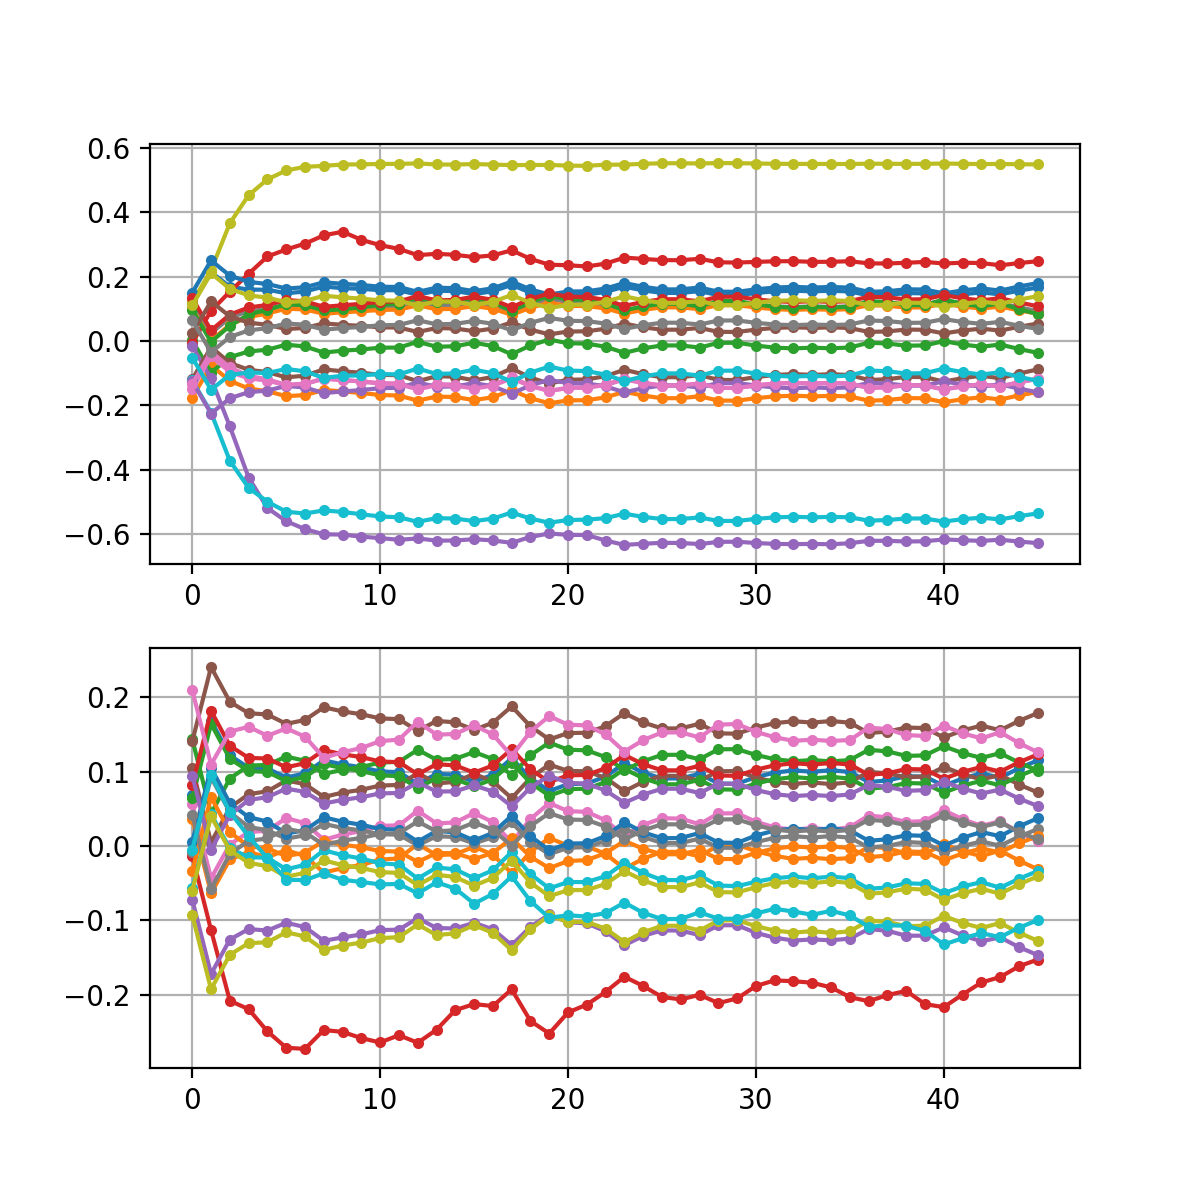

In [33]:
# plot centers history for only some hidden layer neuron
# for full FGN
for k in dev_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(dev_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = dev_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()

hidden_layers.4.sigmas


<IPython.core.display.Javascript object>


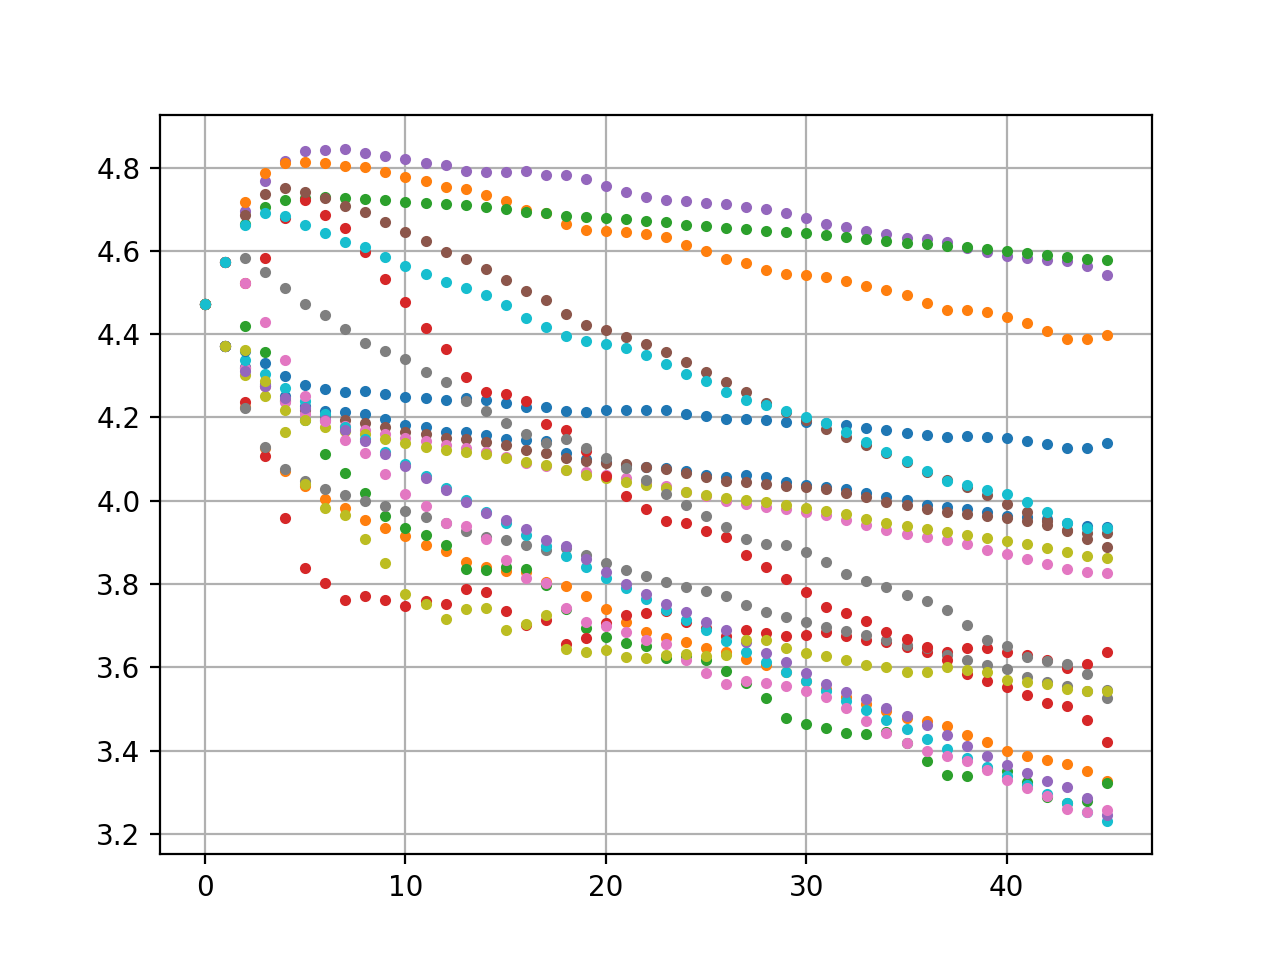

hidden_layers.2.sigmas


<IPython.core.display.Javascript object>


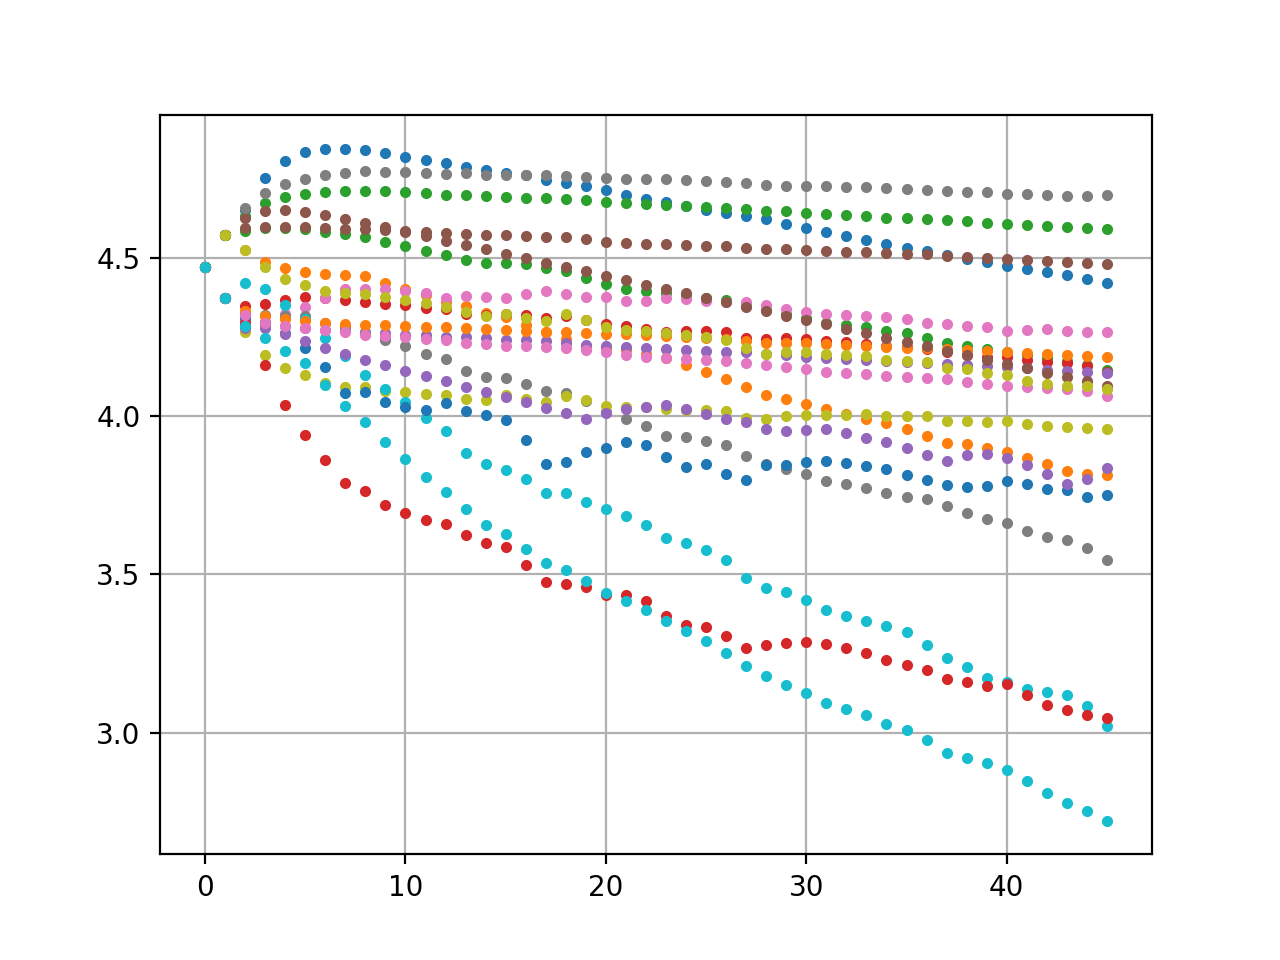

fl.sigmas


<IPython.core.display.Javascript object>


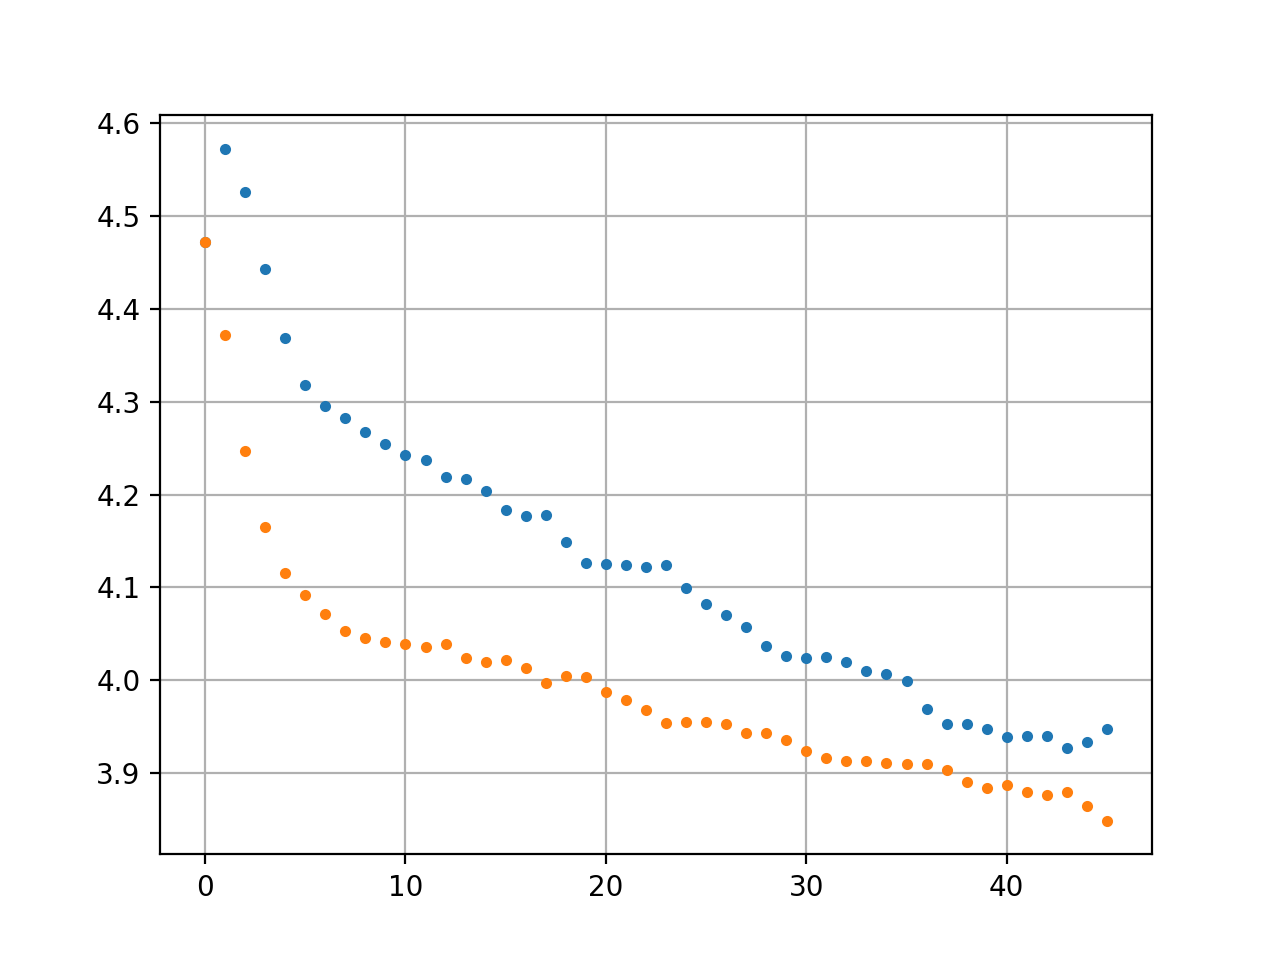

hidden_layers.6.sigmas


<IPython.core.display.Javascript object>


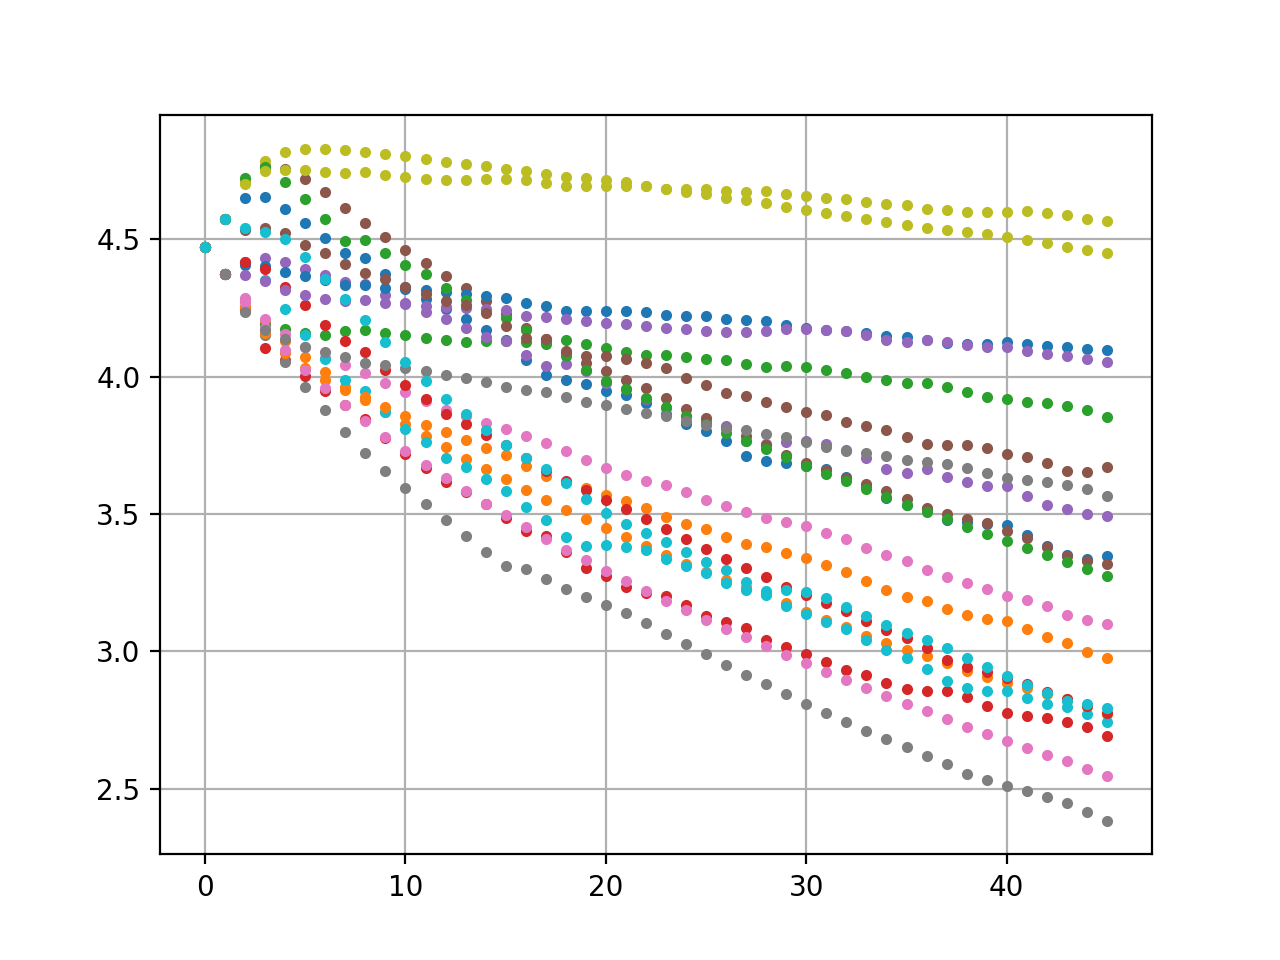

hidden_layers.0.sigmas


<IPython.core.display.Javascript object>


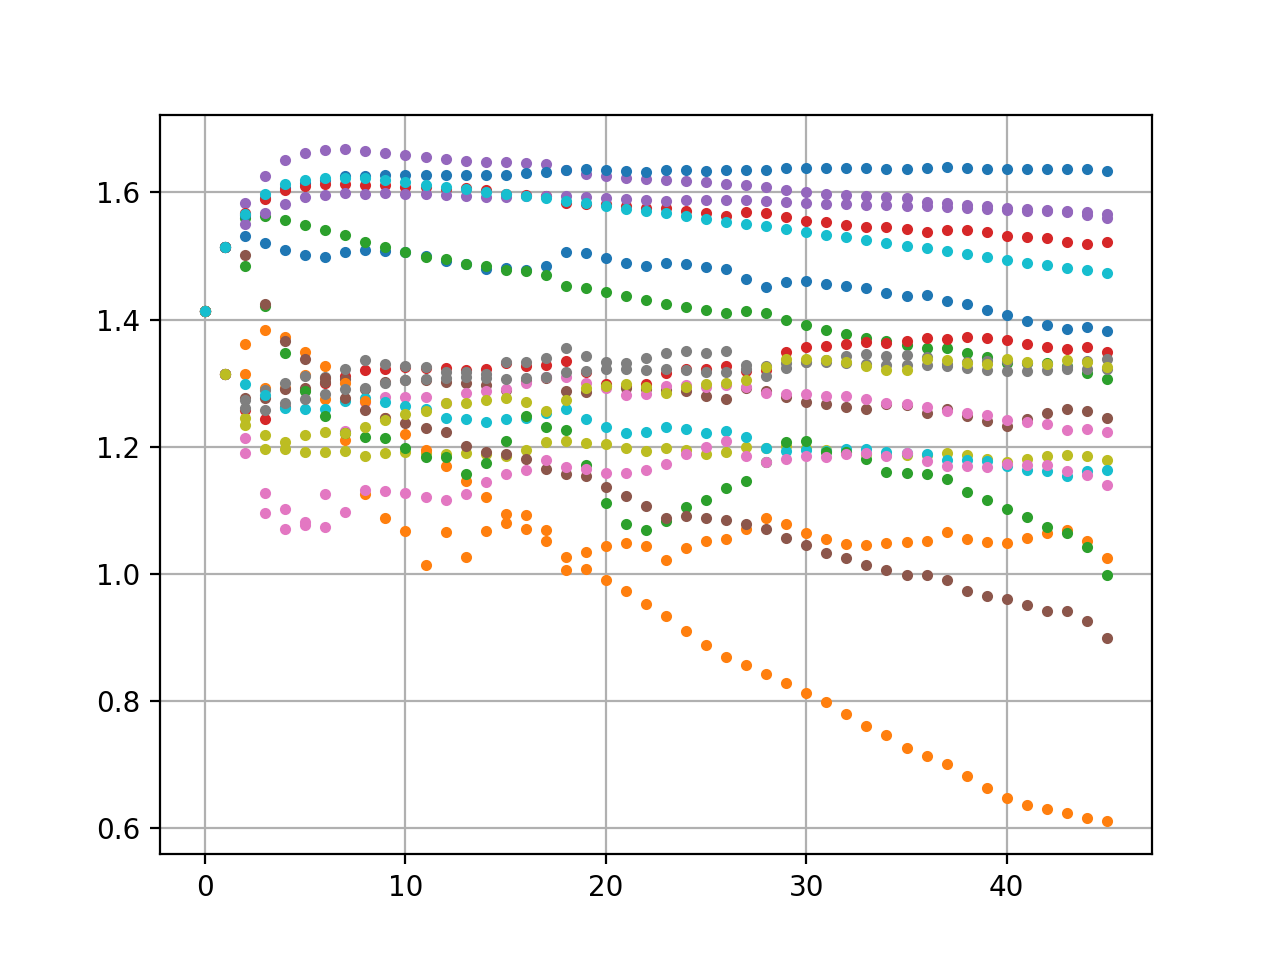

In [34]:
# check that sigma has shrunk
# plot sigma history
for k in dev_train_res['histories'].keys():
    if 'sigmas' in k:
        print(k)
        for i in range(len(dev_train_res['histories'][k][0])):
            plt.plot(dev_train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()